<a href="https://colab.research.google.com/github/mvadrev/Emulation/blob/main/UKF_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
from numpy.linalg import norm
from math import sqrt
from scipy.linalg import cholesky
from scipy import linalg
from math import atan2

def f_radar(x, dt):
    """ state transition function for a constant velocity
    aircraft with the state vector [distance, velocity, altitude]"""
    return (np.array([[1, dt, 0],
                  [0,  1, 0],
                  [0,  0, 1]], dtype=float)) @ x

def h_radar(x, radar_pos):
  """Measurement function, return a list [slant_range, elevation_angle]"""
  dim_x = x[0] - radar_pos[0]
  dim_y = x[2] - radar_pos[1]

  slant_range = sqrt(dim_x**2 + dim_y**2)
  elevation_angle = np.arctan2(dim_y, dim_x)
  return slant_range, elevation_angle

In [29]:
class RadarStation:

    def __init__(self, pos, range_std, elev_angle_std):
        self.pos = np.asarray(pos)       
        self.range_std = range_std
        self.elev_angle_std = elev_angle_std

    #https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/10-Unscented-Kalman-Filter.ipynb
    def reading_of(self, ac_pos):
        """ Returns (range, elevation angle) to aircraft.
        Elevation angle is in radians.
        """
        diff = np.subtract(ac_pos, self.pos)
        rng = norm(diff)
        brg = atan2(diff[1], diff[0])
        return rng, brg
        


    # https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/10-Unscented-Kalman-Filter.ipynb
    def noisy_reading(self, ac_pos):
        """ Compute range and elevation angle to aircraft with
        simulated noise"""
        rng, brg = self.reading_of(ac_pos)      
        rng += np.random.randn() * self.range_std
        brg += np.random.randn() * self.elev_angle_std 
        return rng, brg       



class ACSim:   
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std        
        
    def update(self, dt):
        """ Compute and returns next position. Incorporates 
        random variation in velocity. """
        
        dx = self.vel*dt + (np.random.randn() * self.vel_std) * dt      
        self.pos += dx     
        return self.pos

In [109]:
from numpy.linalg import norm
from math import sqrt
from scipy.linalg import cholesky
from scipy import linalg



class UKF:
  def __init__(self, dim_x, dim_z, fx, hx, radar_pos, dt):
    self.dim_x = dim_x
    self.dim_z = dim_z
    self.radar_pos = radar_pos
    self.dt = dt
    self.fx = fx
    self.hx = hx
    self.mu = None
    self.Sigma = None

    
    self.mup = np.zeros(shape=dim_x)
    self.sigmap = np.zeros(shape=(dim_x, dim_x))
    self.z = np.array([[None]*dim_z]).T
    self.Q = np.eye(dim_z)*10
    self.R = np.eye(dim_x)*10
    self.K = np.zeros((dim_x, dim_z))
    self.y = np.zeros((dim_z))
    self.Sigma = None
    self.lambda_ = None
    self.sigmas = None
    self.sigmas_f = None
  

    # self.lambda_, self.wc, self.wm = self.MerweWeightSigmaPoints(len(self.mu), .1, 2., 0.)
  


  def SigmaPoints(self, mu, n, lambda_, Sigma):
    sigmas = np.zeros((2*n+1, n))
    U = linalg.cholesky((n+lambda_)*Sigma) # sqrt

    sigmas[0] = mu
    for k in range (n):
        sigmas[k+1]   = mu + U[k]
        sigmas[n+k+1] = mu - U[k]
    return sigmas

  def MerweWeightSigmaPoints(self, n, alpha, beta, kappa):
    lambda_ = alpha**2 * (n + kappa) - n
    wc = np.full(2*n + 1,  1. / (2*(n + lambda_)))
    wm = np.full(2*n + 1,  1. / (2*(n + lambda_)))
    wc[0] = lambda_ / (n + lambda_) + (1. - alpha**2 + beta)
    wm[0] = lambda_ / (n + lambda_)
    return lambda_, wc, wm

  def unscented_transform(self, sigmas, wm, wc, R):
      mu = np.dot(wm, sigmas)
      kmax, n = sigmas.shape
      P = np.zeros((n, n))
      for k in range(kmax):
          y = sigmas[k] - mu
          P += wc[k] * np.outer(y, y)
      P += R
      return mu, P

  def predict(self):
      # calculate sigma points for given mean and covariance
      print("the mu len", len(self.mu))
      self.lambda_, self.wc, self.wm = self.MerweWeightSigmaPoints(len(self.mu), .1, 2., 0.)
      self.sigmas = self.SigmaPoints(self.mu, len(self.mu), self.lambda_, self.Sigma)
      sigmas = self.sigmas
      sigmas_f = np.zeros(sigmas.shape)

      # self.mu, Sigma = self.unscented_transform(self.sigmas, self.wm, self.wc, self.R)
      self.mu, self.Sigma = self.unscented_transform(self.sigmas, self.wm, self.wc, self.R)

      for i in range(len(sigmas_f)):
        sigmas_f[i] = self.fx(sigmas[i], dt) 
        self.sigmas_f = sigmas_f
      return self.mu, self.Sigma, self.sigmas_f 

  def update(self, z):
    sigmas_f = self.sigmas_f
    wm = self.wm 
    wc = self.wc 
    sigmas_h = np.zeros(shape=(len(sigmas_f), self.dim_z))

    Q = self.Q

    # transform sigma points into measurement space

    for i in range(len(sigmas_f)):
        sigmas_h[i] = self.hx(sigmas_f[i], radar_pos)

    # mean and covariance of prediction passed through UT
    zp, Pz = self.unscented_transform(sigmas_h, wm, wc, Q)

    # compute cross variance of the state and the measurements
    Pxz = np.zeros((len(self.mu), len(zp)))
    for i in range(len(sigmas_f)):
        # print(sigmas_f[i].shape, self.predictMu.shape, sigmas_h[i].shape, zp.shape)
        Pxz += wc[i] * np.outer(sigmas_f[i] - self.mu, sigmas_h[i] - zp)

    K = np.dot(Pxz, np.linalg.inv(Pz)) # Kalman gain

    mu = self.mu + np.dot(K, z - zp)
    Sigma = self.Sigma - np.dot(K, Pz).dot(K.T)
    return mu, Sigma




In [110]:
import matplotlib.pyplot as plt

def plot_radar(xs, t, plot_x=True, plot_vel=True, plot_alt=True):
    xs = np.asarray(xs)
    if plot_x:
        plt.figure()
        plt.plot(t, xs[:, 0]/1000.)
        plt.xlabel('time(sec)')
        plt.ylabel('position(km)')
        plt.tight_layout()
    if plot_vel:
        plt.figure()
        plt.plot(t, xs[:, 1])
        plt.xlabel('time(sec)')
        plt.ylabel('velocity')
        plt.tight_layout()
    if plot_alt:
        plt.figure()
        plt.plot(t, xs[:,2])
        plt.xlabel('time(sec)')
        plt.ylabel('altitude')
        plt.tight_layout()
    plt.show()

the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3
the mu len 3

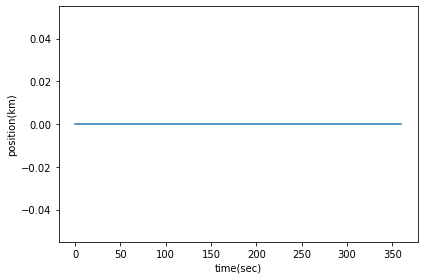

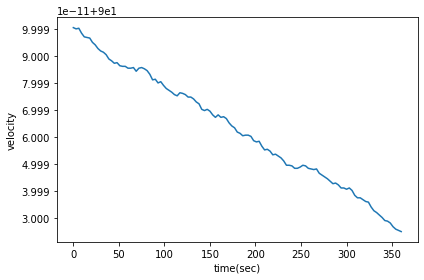

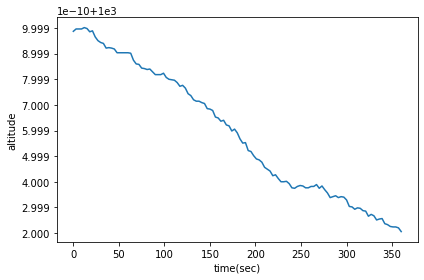

In [111]:
import math
import random

dt = 3. # 12 seconds between readings
range_std = 5 # meters
elevation_angle_std = math.radians(0.5)
ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)

# state of the aircraft
x=np.array([10, 20, 30])

kf = UKF(3, 2, fx=f_radar, hx=h_radar, radar_pos = (0,0), dt = dt)

kf.R[0:2, 0:2] = np.array([[2.025, 1.35 ], [1.35 , 0.9  ]])
kf.R[2,2] = 0.1

kf.Q = np.diag([range_std**2, elevation_angle_std**2])
kf.mu = np.array([0., 90., 1000.])
kf.Sigma = np.diag([300**2, 30**2, 150**2])

np.random.seed(200)
pos = (0, 0)
radar = RadarStation(pos, range_std, elevation_angle_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

time = np.arange(0, 360 + dt, dt)
xs = []
for _ in time:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    # print(r)
    kf.predict()
    # break
    kf.update([r[0], r[1]])
    xs.append(kf.mu)
plot_radar(xs, time)
